#Set Up Environment

Import all the important packages

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
import statsmodels.api as sm
from prettytable import PrettyTable
import os
from dotenv import load_dotenv

# Specify the custom .env file
load_dotenv(dotenv_path='environment_variables.env')

True

Set the env variable.

In [15]:
ProjectName = 'SPX-Industry-Momentum'

os.environ['RESEARCH_PATH']  = os.environ.get('PROJECT_ROOT')
research_path = os.environ.get('RESEARCH_PATH')
if research_path:
    path = os.path.join(research_path, ProjectName)
    print(path)
    file_path = os.path.join(path, 'data', 'raw')
    print(file_path)
else:
    print("RESEARCH_PATH environment variable is not set.")

/Users/marcobischoff/Library/Mobile Documents/3L68KQB4HG~com~readdle~CommonDocuments/Documents/Banking & Finance/Digital Tools for Finance/SPX-Industry-Momentum
/Users/marcobischoff/Library/Mobile Documents/3L68KQB4HG~com~readdle~CommonDocuments/Documents/Banking & Finance/Digital Tools for Finance/SPX-Industry-Momentum/data/raw


# Define all the functions

In [16]:
def getFirstAndLastDayInPeriod(dateList, nDigits):
    """
    Generate arrays listing the first and last observation in each period.
    Dates should be provided as numeric in the format YYYYMMDD, YYMMDD, or
    MMDD. The granularity of the period is defined by the number of digits
    that are removed from the date list. 2 digits will convert daily data to
    monthly data or monthly data to annual data. 4 digits will convert
    daily data to annual data.
    """
    # Ensure dateList is a list of integers
    dateList = [int(date) for date in dateList]

    # Begin by marking the last observation in each period in the data
    nObs = len(dateList)
    scalingFactor = 1 / 10**nDigits
    trimmedDate = np.round(np.array(dateList) * scalingFactor)
    isNewPeriod = np.diff(trimmedDate)

    # Generate a list with the last days, and use it to generate the list of
    # the first days
    lastDayList = np.where(isNewPeriod)[0]
    firstDayList = lastDayList + 1
    lastDayList = np.append(lastDayList, nObs - 1)  # Add the last day in the sample
    firstDayList = np.insert(firstDayList, 0, 0)    # Add the first day in the sample

    return firstDayList, lastDayList

In [17]:
def adjust_interest_rates(interest_rates, numericDate_d):
    """
    interest_rates: daily interest rates p.a, e.g., 0.05
    date_list: daily dates in numeric format yyyymmdd

    Returns interest rates after adjusting for different period lengths
    """
    # Convert numericDate_d to datetime format
    date_in_datetime_format = pd.to_datetime(numericDate_d.astype(str), format='%Y%m%d')

    # Convert datetime objects to an array of day counts since the epoch
    day_counts = (date_in_datetime_format - pd.Timestamp('1970-01-01')) / np.timedelta64(1, 'D')

    # Calculate the difference in days between consecutive dates
    df = np.diff(day_counts)
    df = np.append(df, 0)

    # Adjust interest rates for different period lengths
    rf_d = interest_rates * (df[:, None] * np.ones((1, interest_rates.shape[1]))) / 360

    return rf_d

In [18]:
def aggregateReturns(originalReturns, dateList, nDigits):
    """
    Aggregates returns over time per asset.
    The original set of returns should be ordinary returns.
    Dates should be provided as numeric in the format YYYYMMDD, YYMMDD, or
    MMDD. The desired aggregation level is defined by the number of digits
    that are removed from the date list. 2 digits will aggregate daily returns
    to monthly ones or monthly returns to annual ones. 4 digits will convert
    daily returns to annual returns.
    """

    originalReturns = originalReturns.values

    # Get the first and last day of each period
    firstDayList, lastDayList = getFirstAndLastDayInPeriod(dateList, nDigits)

    # Check if originalReturns is one-dimensional and reshape if necessary
    if np.ndim(originalReturns) == 1:
        originalReturns = originalReturns[:, np.newaxis]  # add an extra dimension

    # Compound the returns during the period for each asset
    nPeriods = len(firstDayList)
    nAssets = originalReturns.shape[1]
    aggregatedReturns = np.zeros((nPeriods, nAssets))

    for n in range(nPeriods):
        first = firstDayList[n]
        last = lastDayList[n]
        for asset in range(nAssets):
            # Index the originalReturns NumPy array using the date range
            returns_subset = originalReturns[first:last + 1, asset]
            aggregatedReturns[n, asset] = np.prod(1 + returns_subset) - 1

    return aggregatedReturns

In [19]:
def computeSortWeights(sortVariable, nLongs, nShorts, longHighValues):
    """
    Generates portfolio weights based on sortVariable.
    The function ignores assets for which the sort variable is missing (NaN).
    All such assets get a weight of zero in the portfolio.
    nLongs and nShorts denote the number of assets held long and short.
    When longHighValues is True, assets that have the highest values for
    sortVariable are held long and those with the lowest values are held
    short. Otherwise, the opposite holds.
    """

    # Ensure sortVariable is a numpy array
    sortVariable = np.array(sortVariable)

    # Initialize weights with zeros
    weights = np.zeros(len(sortVariable))

    # Filter out NaN values and get their indices
    valid_indices = np.where(~np.isnan(sortVariable))[0]
    valid_values = sortVariable[valid_indices]

    # Get sorted indices based on valid_values
    if longHighValues:
        sorted_indices = np.argsort(valid_values)[::-1] # From high to low
    else:
        sorted_indices = np.argsort(valid_values)      # From low to high

    # Assign weights to longs only if nLongs is not zero
    if nLongs != 0:
        long_indices = valid_indices[sorted_indices[:nLongs]]
        weights[long_indices] = 1.0 / nLongs

    # Assign weights to shorts only if nShorts is not zero
    if nShorts != 0:
        short_indices = valid_indices[sorted_indices[-nShorts:]]
        weights[short_indices] = -1.0 / nShorts

    return weights

In [20]:
def compute_turnover(previous_weights, new_weights, asset_returns):
    # Ensuring the inputs are NumPy arrays for correct operations
    previous_weights = np.abs(np.array(previous_weights))
    new_weights = np.abs(np.array(new_weights))
    asset_returns = np.array(asset_returns)

    # Calculating portfolio return excluding transaction costs, Rp
    rp = np.nansum(previous_weights * (1 + asset_returns))

    # Calculating value per asset
    value_per_asset = previous_weights * (1 + asset_returns)

    # Calculating current weights
    if rp == 0:
        current_weights = np.zeros_like(previous_weights)  # Set current_weights to zero if rp is zero
    else:
        current_weights = value_per_asset / rp  # No indexing needed since rp is a scalar

    current_weights[np.isnan(current_weights)] = 0  # Replacing NaN values with 0

    # Calculating turnover
    turnover = np.nansum(np.abs(new_weights - current_weights))

    return turnover, rp

In [21]:
def pmpBacktestMomentum(returns_d, rf_d, numericDate_d, lookback_period_start, lookback_period_end, holding_period, tradingLag, startMonth, nLong, nShort, trx_cost):
    # Aggregate daily returns to monthly returns:
    returns_m = aggregateReturns(returns_d, numericDate_d, 2)
    rf_m = aggregateReturns(rf_d, numericDate_d, 2)

    # Extract first and last day of month and some base variables
    nMonths, nSectors = returns_m.shape

    # possible assets to choose from
    possible_assets = np.ones((nMonths, nSectors))
    possible_assets[:lookback_period_start, :] = 0
    possible_assets[lookback_period_start:, :] = ~np.isnan(returns_m[lookback_period_start:, :])

    # Calculate cumulative monthly returns over lookback_period
    past_r_temp = np.cumprod(returns_m + 1, axis=0)
    past_r_temp[np.isnan(returns_m)] = np.nan

    past_returns_m = np.zeros((nMonths, nSectors))
    past_returns_m[lookback_period_start:] = (past_r_temp[lookback_period_start - lookback_period_end:-lookback_period_end] / past_r_temp[:-lookback_period_start]) * (1 + returns_m[:-lookback_period_start])

    # Adjust for trading lag
    if lookback_period_end == 1 and tradingLag != 0:
      for month in range(lookback_period_start, nMonths):
        past_returns_m[month, :] = past_returns_m[month, :] / np.prod(1 + returns_d[LastDayList[month-1]-tradingLag:LastDayList[month-1], :], axis=0)

    past_returns_m[~possible_assets.astype(bool)] = np.nan

    weights_long = np.zeros((nMonths, nSectors))
    weights_short = np.zeros((nMonths, nSectors))
    turnover_long = np.zeros(nMonths)
    turnover_short = np.zeros(nMonths)

    for month in range(startMonth, nMonths):

      if month == startMonth or (month - startMonth) % holding_period == 0:
          # Compute new target weights
          new_weights_long = computeSortWeights(past_returns_m[month, :], nLong, 0, True)
          new_weights_short = computeSortWeights(past_returns_m[month, :], 0, nShort, True)

          # Adjust for holding period
          delta_long = (new_weights_long - weights_long[month-1, :]) / holding_period
          delta_short = (new_weights_short - weights_short[month-1, :]) / holding_period

          weights_long[month, :] = weights_long[month-1, :] + delta_long
          weights_short[month, :] = weights_short[month-1, :] + delta_short
      else:
          weights_long[month, :] = weights_long[month-1, :]
          weights_short[month, :] = weights_short[month-1, :]

      # Ensure the sum of absolute weights equals one
      total_long_weight = np.sum(np.abs(weights_long[month, :]))
      total_short_weight = np.sum(np.abs(weights_short[month, :]))

      weights_long[month, :] /= total_long_weight
      weights_short[month, :] /= total_short_weight

      turnover_long[month], _ = compute_turnover(weights_long[month-1, :], weights_long[month, :], returns_m[month-1, :])
      turnover_short[month], _ = compute_turnover(weights_short[month-1, :], weights_short[month, :], returns_m[month-1, :])

    totalReturnsLong = np.nansum(weights_long * returns_m, axis=1)
    totalReturnsShort = np.nansum(weights_short * returns_m, axis=1)
    xsReturns = np.zeros(nMonths)

    if nShort == 0:
      xsReturns[startMonth:] = totalReturnsLong[startMonth:] - rf_m[startMonth:].squeeze()
      weights = weights_long
    else:
      xsReturns = totalReturnsLong + totalReturnsShort
      weights = weights_long + weights_short

    xsReturns_TC = xsReturns - (np.abs(turnover_long) + np.abs(turnover_short)) * trx_cost
    totalReturns_TC = xsReturns_TC + np.concatenate([np.zeros(startMonth), rf_m[startMonth:].squeeze()])

    return xsReturns, xsReturns_TC, totalReturns_TC, weights


In [22]:
def summarizePerformance(xsReturns, Rf, factorXsReturns, annualizationFactor, startM, txt):

    # Shorten Series
    xsReturns = xsReturns[startM:]
    factorXsReturns = factorXsReturns[startM:]
    Rf = Rf[startM:]
    if len(xsReturns.shape) == 1:
      nPeriods = len(xsReturns)
      nAssets = 1
      xsReturns = xsReturns[:, np.newaxis]  # Convert to 2D for consistency
    else:
      nPeriods, nAssets = xsReturns.shape
    totalReturns = xsReturns + np.outer(Rf, np.ones(nAssets))

    # Compute the terminal value of the portfolios to get the geometric mean return per period
    FinalPfValRf = np.prod(1 + Rf)
    FinalPfValTotalRet = np.prod(1 + totalReturns, axis=0)
    GeomAvgRf = 100 * (FinalPfValRf ** (annualizationFactor / nPeriods) - 1)
    GeomAvgTotalReturn = 100 * (FinalPfValTotalRet ** (annualizationFactor / nPeriods) - 1)
    GeomAvgXsReturn = GeomAvgTotalReturn - GeomAvgRf

    # Regress returns on benchmark to get alpha and factor exposures
    X = np.column_stack((np.ones(nPeriods), factorXsReturns))
    betas, _, _, _ = np.linalg.lstsq(X, xsReturns, rcond=None)
    betas = betas[1:]

    bmRet = factorXsReturns.dot(betas) + np.outer(Rf, np.ones(nAssets))
    FinalPfValBm = np.prod(1 + bmRet, axis=0)
    GeomAvgBmReturn = 100 * (FinalPfValBm ** (annualizationFactor / nPeriods) - 1)
    alphaGeometric = GeomAvgTotalReturn - GeomAvgBmReturn

    alpha_monthly_timeseries = totalReturns - factorXsReturns.dot(np.ones((nAssets, nAssets)))
    GeoAlphaDeannualized = (1 + (alphaGeometric / 100)) ** (1 / annualizationFactor) - 1
    std_alpha_monthly = np.std(alpha_monthly_timeseries, axis=0)
    SE_alpha = std_alpha_monthly / np.sqrt(nPeriods)
    tvaluealpha = GeoAlphaDeannualized / SE_alpha

    # Rescale the returns to be in percentage points
    xsReturns = 100 * xsReturns
    totalReturns = 100 * totalReturns

    # Compute first three autocorrelations
    AC1 = np.diag(np.corrcoef(xsReturns[:-1].T, xsReturns[1:].T)[nAssets:2*nAssets, :nAssets])
    AC2 = np.diag(np.corrcoef(xsReturns[:-2].T, xsReturns[2:].T)[nAssets:2*nAssets, :nAssets])
    AC3 = np.diag(np.corrcoef(xsReturns[:-3].T, xsReturns[3:].T)[nAssets:2*nAssets, :nAssets])

    # Report the statistics
    ArithmAvgTotalReturn = annualizationFactor * np.mean(totalReturns, axis=0)
    ArithmAvgXsReturn = annualizationFactor * np.mean(xsReturns, axis=0)
    StdXsReturns = np.sqrt(annualizationFactor) * np.std(xsReturns, axis=0)
    SharpeArithmetic = ArithmAvgXsReturn / StdXsReturns
    SharpeGeometric = GeomAvgXsReturn / StdXsReturns
    MinXsReturn = np.min(xsReturns, axis=0)
    MaxXsReturn = np.max(xsReturns, axis=0)
    SkewXsReturn = skew(xsReturns, axis=0)
    KurtXsReturn = kurtosis(xsReturns, axis=0)
    alphaArithmetic = annualizationFactor * 100 * betas[0]

    print(f'Performance Statistics for {txt}')

    # Create table
    x = PrettyTable()
    x.field_names = ["Statistic", "Value"]

    x.add_row(["ArithmAvgTotalReturn", ArithmAvgTotalReturn])
    x.add_row(["ArithmAvgXsReturn", ArithmAvgXsReturn])
    x.add_row(["StdXsReturns", StdXsReturns])
    x.add_row(["SharpeArithmetic", SharpeArithmetic])
    x.add_row(["SharpeGeometric", SharpeGeometric])
    x.add_row(["MinXsReturn", MinXsReturn])
    x.add_row(["MaxXsReturn", MaxXsReturn])
    x.add_row(["SkewXsReturn", SkewXsReturn])
    x.add_row(["KurtXsReturn", KurtXsReturn])
    x.add_row(["alphaArithmetic", alphaArithmetic])

    print(x)

    return (ArithmAvgTotalReturn, ArithmAvgXsReturn, StdXsReturns, SharpeArithmetic, MinXsReturn, MaxXsReturn, SkewXsReturn, KurtXsReturn, alphaArithmetic, tvaluealpha, betas)

#Load the data

In [24]:
# Define which Excel to Load
Excel_file_name = 'Data for Project.xlsx'

# Load the Excel file
Excel_file_path = os.path.join(file_path, Excel_file_name)

xls = pd.ExcelFile(Excel_file_path)

# Create a dictionary where keys are sheet names and values are the dataframes
dfs = {sheet_name: xls.parse(sheet_name) for sheet_name in xls.sheet_names}

for sheet_name, df in dfs.items():
    exec(f"{sheet_name} = df")

#Modify and process the data

In [25]:
# Define meta variables for the analysis
trx_cost = 0.001;
nLong = 3;
nShort = 0;
startMonth = 101;
tradingLag = 0;
lookback_period_start = 9
lookback_period_end = 1
holding_period = 3
trading_lag = 0
myLineWidth = 2
RobustnessCheckColor = 'blue'

# Process the data

# Dates
dates_dateformat = Rf.iloc[:, 0].dt.strftime('%Y%m%d')
numericDate_d = dates_dateformat.astype(int)
firstDayList, lastDayList = getFirstAndLastDayInPeriod(numericDate_d, 2)
dates4plot = [dates_dateformat[i] for i in firstDayList]

# Returns
returns_d = TRSP500.iloc[:, 2:].pct_change()
returns_d = returns_d.iloc[1:]
returns_SPX = TRSP500.iloc[:, 1].pct_change()
returns_SPX = returns_SPX.iloc[1:]
returns_SPX_monthly = aggregateReturns(returns_SPX, numericDate_d, 2)
rf_d_unadjusted = Rf.iloc[:,1:] / 100
rf_d = adjust_interest_rates(rf_d_unadjusted,numericDate_d)
rf_d_monthly = aggregateReturns(rf_d, numericDate_d, 2)

In [26]:
rf_d

,GB03 Govt
0,0.000220
1,0.000218
2,0.000216
3,0.000217
4,0.000648
...,...
8765,0.000141
8766,0.000142
8767,0.000142
8768,0.000141


In [27]:
xsReturns, xsReturns_TC, totalReturns_TC, weights = pmpBacktestMomentum(returns_d, rf_d, numericDate_d, lookback_period_start, lookback_period_end, holding_period, tradingLag, startMonth, nLong, nShort, trx_cost)

/var/folders/7m/vw_x51f92rbdyw9syfzqp4b80000gn/T/ipykernel_5322/3603478292.py:55: RuntimeWarning: divide by zero encountered in divide
  weights_short[month, :] /= total_short_weight
/var/folders/7m/vw_x51f92rbdyw9syfzqp4b80000gn/T/ipykernel_5322/3603478292.py:55: RuntimeWarning: invalid value encountered in divide
  weights_short[month, :] /= total_short_weight


#Calculate and plot the results

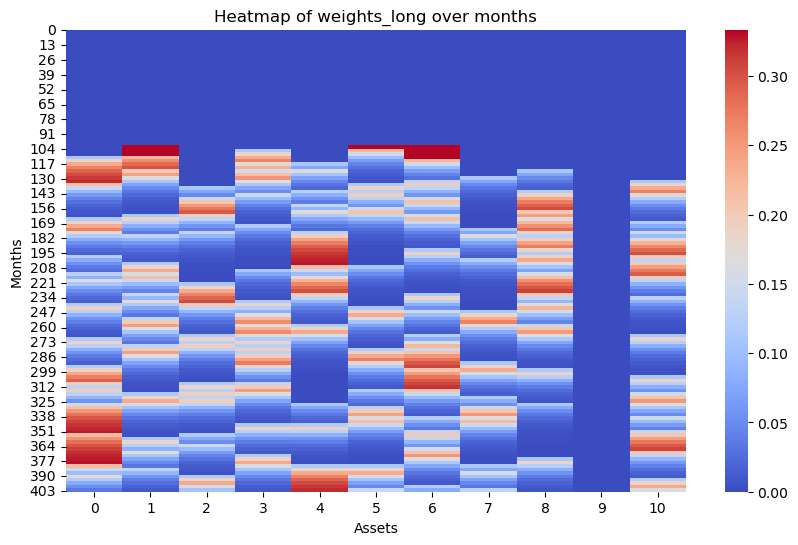

In [28]:
plt.figure(figsize=(10, 6))
sns.heatmap(weights, cmap='coolwarm', cbar=True)
plt.title("Heatmap of weights_long over months")
plt.xlabel("Assets")
plt.ylabel("Months")
plt.show()

In [29]:
cumulative_strategy_returns = np.cumprod(1 + totalReturns_TC[startMonth:]) - 1
cumulative_benchmark_returns = np.cumprod(1 + returns_SPX_monthly[startMonth:].squeeze()) - 1

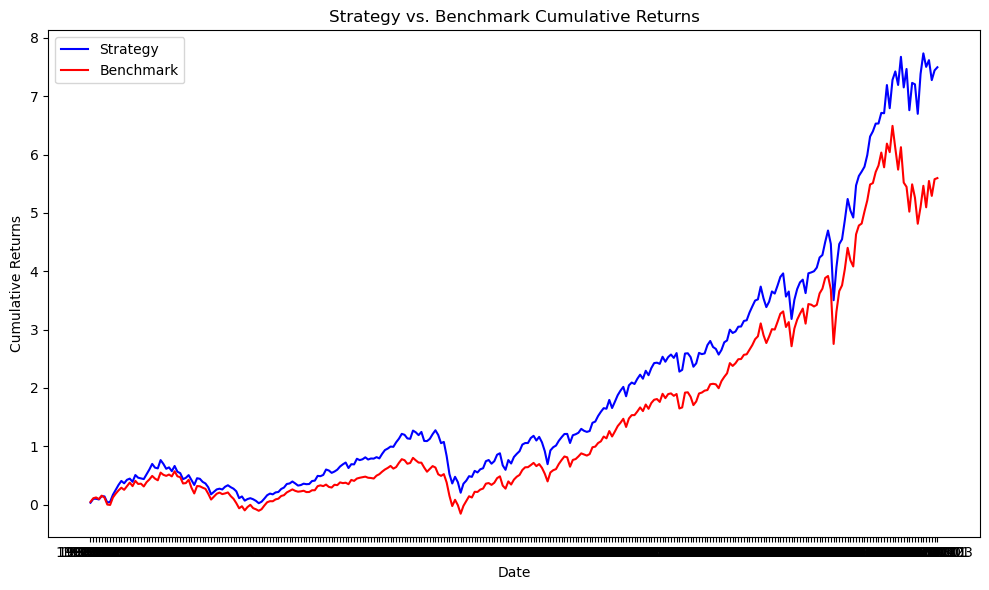

In [30]:
# Create a new figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the strategy and benchmark returns
ax.plot(dates4plot[startMonth:], cumulative_strategy_returns, label='Strategy', color='blue')
ax.plot(dates4plot[startMonth:], cumulative_benchmark_returns, label='Benchmark', color='red')

# Add labels, title, and legend
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Returns')
ax.set_title('Strategy vs. Benchmark Cumulative Returns')
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [31]:
ArithmAvgTotalReturn, ArithmAvgXsReturn, StdXsReturns, SharpeArithmetic, MinXsReturn, MaxXsReturn, SkewXsReturn, KurtXsReturn, alphaArithmetic, tvaluealpha, betas = summarizePerformance(xsReturns_TC, rf_d_monthly, returns_SPX_monthly, 12, startMonth, "Momentum")

Performance Statistics for Momentum
+----------------------+----------------+
|      Statistic       |     Value      |
+----------------------+----------------+
| ArithmAvgTotalReturn |  [9.78478786]  |
|  ArithmAvgXsReturn   |  [7.92700959]  |
|     StdXsReturns     | [15.90519145]  |
|   SharpeArithmetic   |  [0.49839133]  |
|   SharpeGeometric    |  [0.43833249]  |
|     MinXsReturn      | [-17.65697321] |
|     MaxXsReturn      | [13.92357367]  |
|     SkewXsReturn     | [-0.62847198]  |
|     KurtXsReturn     |  [1.50404537]  |
|   alphaArithmetic    | [1063.5586891] |
+----------------------+----------------+


#Robustness Checks

Performance Statistics for Momentum
+----------------------+-----------------+
|      Statistic       |      Value      |
+----------------------+-----------------+
| ArithmAvgTotalReturn |   [9.18964219]  |
|  ArithmAvgXsReturn   |   [7.33186391]  |
|     StdXsReturns     |  [15.19277186]  |
|   SharpeArithmetic   |   [0.48258896]  |
|   SharpeGeometric    |   [0.42430918]  |
|     MinXsReturn      |  [-19.80224868] |
|     MaxXsReturn      |  [13.23718937]  |
|     SkewXsReturn     |  [-0.72115336]  |
|     KurtXsReturn     |   [2.14515561]  |
|   alphaArithmetic    | [1022.68371482] |
+----------------------+-----------------+
Performance Statistics for Momentum
+----------------------+-----------------+
|      Statistic       |      Value      |
+----------------------+-----------------+
| ArithmAvgTotalReturn |   [9.98533751]  |
|  ArithmAvgXsReturn   |   [8.12755923]  |
|     StdXsReturns     |  [15.76554673]  |
|   SharpeArithmetic   |   [0.51552663]  |
|   SharpeGeometric    | 

/var/folders/7m/vw_x51f92rbdyw9syfzqp4b80000gn/T/ipykernel_5322/3603478292.py:55: RuntimeWarning: divide by zero encountered in divide
  weights_short[month, :] /= total_short_weight
/var/folders/7m/vw_x51f92rbdyw9syfzqp4b80000gn/T/ipykernel_5322/3603478292.py:55: RuntimeWarning: invalid value encountered in divide
  weights_short[month, :] /= total_short_weight


Performance Statistics for Momentum
+----------------------+-----------------+
|      Statistic       |      Value      |
+----------------------+-----------------+
| ArithmAvgTotalReturn |   [9.43054426]  |
|  ArithmAvgXsReturn   |   [7.57276598]  |
|     StdXsReturns     |  [15.62492717]  |
|   SharpeArithmetic   |   [0.48465928]  |
|   SharpeGeometric    |   [0.42466563]  |
|     MinXsReturn      |  [-20.43958153] |
|     MaxXsReturn      |  [13.70901102]  |
|     SkewXsReturn     |  [-0.65254058]  |
|     KurtXsReturn     |   [1.90564099]  |
|   alphaArithmetic    | [1052.75189569] |
+----------------------+-----------------+
Performance Statistics for Momentum
+----------------------+----------------+
|      Statistic       |     Value      |
+----------------------+----------------+
| ArithmAvgTotalReturn | [10.27242902]  |
|  ArithmAvgXsReturn   |  [8.41465074]  |
|     StdXsReturns     | [15.37618309]  |
|   SharpeArithmetic   |  [0.54725225]  |
|   SharpeGeometric    |  [0.493

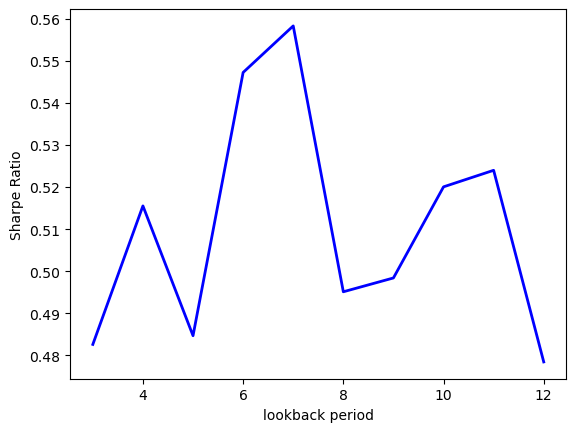

In [32]:
# Define parameters and initialize empty lists or arrays
lookback_period_loop = range(3, 13)
sharpRatio_mom_lb_loop = [0] * len(lookback_period_loop)

# Iterate over the lookback periods
for i, lb_period in enumerate(lookback_period_loop):
    _, xsReturns_mom_TC_lb, _, _ = pmpBacktestMomentum(returns_d, rf_d, numericDate_d, lb_period, lookback_period_end, holding_period, tradingLag, startMonth, nLong, nShort, trx_cost)
    _, _, _, sharpRatio_mom, _, _, _, _, _, _, _ = summarizePerformance(xsReturns_mom_TC_lb, rf_d_monthly, returns_SPX_monthly, 12, startMonth, "Momentum")

    sharpRatio_mom_lb_loop[i] = sharpRatio_mom

# Plot the results
plt.figure()
plt.plot(lookback_period_loop, sharpRatio_mom_lb_loop, linewidth=myLineWidth, color=RobustnessCheckColor)
plt.xlabel("lookback period")
plt.ylabel("Sharpe Ratio")
plt.savefig('Lookback_Check.jpg')
plt.show()

/var/folders/7m/vw_x51f92rbdyw9syfzqp4b80000gn/T/ipykernel_5322/3603478292.py:55: RuntimeWarning: divide by zero encountered in divide
  weights_short[month, :] /= total_short_weight
/var/folders/7m/vw_x51f92rbdyw9syfzqp4b80000gn/T/ipykernel_5322/3603478292.py:55: RuntimeWarning: invalid value encountered in divide
  weights_short[month, :] /= total_short_weight


Performance Statistics for Momentum
+----------------------+-----------------+
|      Statistic       |      Value      |
+----------------------+-----------------+
| ArithmAvgTotalReturn |   [9.18964219]  |
|  ArithmAvgXsReturn   |   [7.33186391]  |
|     StdXsReturns     |  [15.19277186]  |
|   SharpeArithmetic   |   [0.48258896]  |
|   SharpeGeometric    |   [0.42430918]  |
|     MinXsReturn      |  [-19.80224868] |
|     MaxXsReturn      |  [13.23718937]  |
|     SkewXsReturn     |  [-0.72115336]  |
|     KurtXsReturn     |   [2.14515561]  |
|   alphaArithmetic    | [1022.68371482] |
+----------------------+-----------------+
Performance Statistics for Momentum
+----------------------+-----------------+
|      Statistic       |      Value      |
+----------------------+-----------------+
| ArithmAvgTotalReturn |   [9.98533751]  |
|  ArithmAvgXsReturn   |   [8.12755923]  |
|     StdXsReturns     |  [15.76554673]  |
|   SharpeArithmetic   |   [0.51552663]  |
|   SharpeGeometric    | 

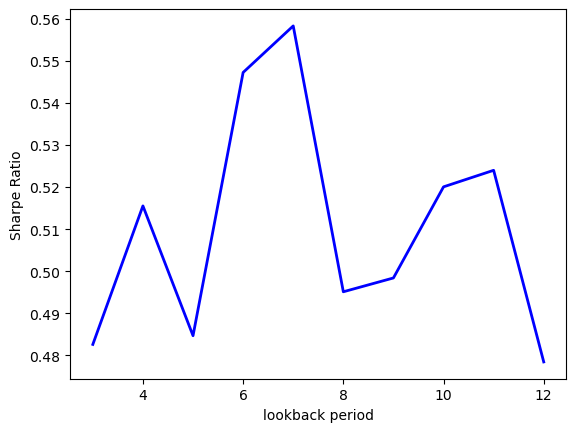

In [33]:
# Define parameters and initialize empty lists or arrays
lookback_period_loop = range(3, 13)
sharpRatio_mom_lb_loop = [0] * len(lookback_period_loop)

# Iterate over the lookback periods
for i, lb_period in enumerate(lookback_period_loop):
    _, xsReturns_mom_TC_lb, _, _ = pmpBacktestMomentum(returns_d, rf_d, numericDate_d, lb_period, lookback_period_end, holding_period, tradingLag, startMonth, nLong, nShort, trx_cost)
    _, _, _, sharpRatio_mom, _, _, _, _, _, _, _ = summarizePerformance(xsReturns_mom_TC_lb, rf_d_monthly, returns_SPX_monthly, 12, startMonth, "Momentum")

    sharpRatio_mom_lb_loop[i] = sharpRatio_mom

# Plot the results
plt.figure()
plt.plot(lookback_period_loop, sharpRatio_mom_lb_loop, linewidth=myLineWidth, color=RobustnessCheckColor)
plt.xlabel("lookback period")
plt.ylabel("Sharpe Ratio")
plt.savefig('Lookback_Check.jpg')
plt.show()

/var/folders/7m/vw_x51f92rbdyw9syfzqp4b80000gn/T/ipykernel_5322/3603478292.py:55: RuntimeWarning: divide by zero encountered in divide
  weights_short[month, :] /= total_short_weight
/var/folders/7m/vw_x51f92rbdyw9syfzqp4b80000gn/T/ipykernel_5322/3603478292.py:55: RuntimeWarning: invalid value encountered in divide
  weights_short[month, :] /= total_short_weight


Performance Statistics for mom_inv_horizon
+----------------------+----------------+
|      Statistic       |     Value      |
+----------------------+----------------+
| ArithmAvgTotalReturn |  [7.79444979]  |
|  ArithmAvgXsReturn   |  [5.93667151]  |
|     StdXsReturns     | [16.05756202]  |
|   SharpeArithmetic   |  [0.36971188]  |
|   SharpeGeometric    |  [0.29965453]  |
|     MinXsReturn      | [-18.87340303] |
|     MaxXsReturn      | [12.61374637]  |
|     SkewXsReturn     | [-0.60427922]  |
|     KurtXsReturn     |  [1.07350819]  |
|   alphaArithmetic    | [957.12553527] |
+----------------------+----------------+
Performance Statistics for mom_inv_horizon
+----------------------+----------------+
|      Statistic       |     Value      |
+----------------------+----------------+
| ArithmAvgTotalReturn |  [9.06097294]  |
|  ArithmAvgXsReturn   |  [7.20319466]  |
|     StdXsReturns     | [15.64518592]  |
|   SharpeArithmetic   |  [0.46040966]  |
|   SharpeGeometric    |  [0.398

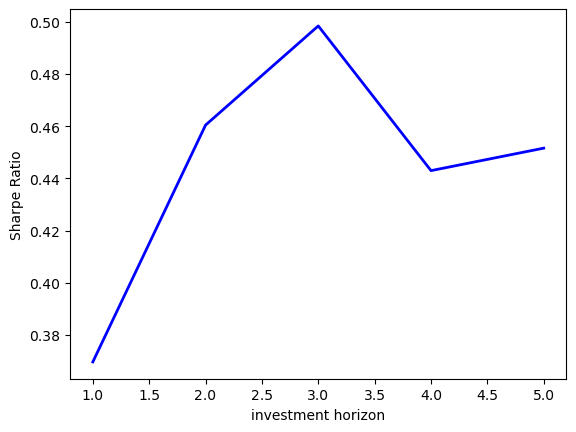

In [34]:
# Define parameters and initialize empty lists or arrays
investment_horizon_loop = range(1, 6)
sharpRatio_investment_horizon_loop = [0] * len(investment_horizon_loop)

# Iterate over the investment horizons
for i, inv_horizon in enumerate(investment_horizon_loop):
    # Based on your MATLAB code, lookback period start is fixed at 9, lookback period end is fixed at 1
    _, xsReturns_mom_TC_lb, _, _ = pmpBacktestMomentum(returns_d, rf_d, numericDate_d, lookback_period_start, lookback_period_end, inv_horizon, tradingLag, startMonth, nLong, nShort, trx_cost)
    _, _, _, sharpRatio_mom, _, _, _, _, _, _, _ = summarizePerformance(xsReturns_mom_TC_lb, rf_d_monthly, returns_SPX_monthly, 12, startMonth, 'mom_inv_horizon')

    sharpRatio_investment_horizon_loop[i] = sharpRatio_mom

# Plot the results
plt.figure()
plt.plot(investment_horizon_loop, sharpRatio_investment_horizon_loop, linewidth=myLineWidth, color=RobustnessCheckColor)
plt.xlabel("investment horizon")
plt.ylabel("Sharpe Ratio")
plt.savefig('InvestmentHorizon_Check.jpg')
plt.show()

/var/folders/7m/vw_x51f92rbdyw9syfzqp4b80000gn/T/ipykernel_5322/3603478292.py:55: RuntimeWarning: divide by zero encountered in divide
  weights_short[month, :] /= total_short_weight
/var/folders/7m/vw_x51f92rbdyw9syfzqp4b80000gn/T/ipykernel_5322/3603478292.py:55: RuntimeWarning: invalid value encountered in divide
  weights_short[month, :] /= total_short_weight


Performance Statistics for mom_inv_horizon
+----------------------+-----------------+
|      Statistic       |      Value      |
+----------------------+-----------------+
| ArithmAvgTotalReturn |  [11.48046987]  |
|  ArithmAvgXsReturn   |   [9.62269159]  |
|     StdXsReturns     |  [19.19298367]  |
|   SharpeArithmetic   |   [0.50136507]  |
|   SharpeGeometric    |   [0.42617353]  |
|     MinXsReturn      |  [-18.03296263] |
|     MaxXsReturn      |  [17.09400715]  |
|     SkewXsReturn     |  [-0.48218292]  |
|     KurtXsReturn     |   [1.14163596]  |
|   alphaArithmetic    | [1094.02385668] |
+----------------------+-----------------+
Performance Statistics for mom_inv_horizon
+----------------------+-----------------+
|      Statistic       |      Value      |
+----------------------+-----------------+
| ArithmAvgTotalReturn |  [10.29357122]  |
|  ArithmAvgXsReturn   |   [8.43579294]  |
|     StdXsReturns     |  [16.62997229]  |
|   SharpeArithmetic   |   [0.5072644]   |
|   SharpeG

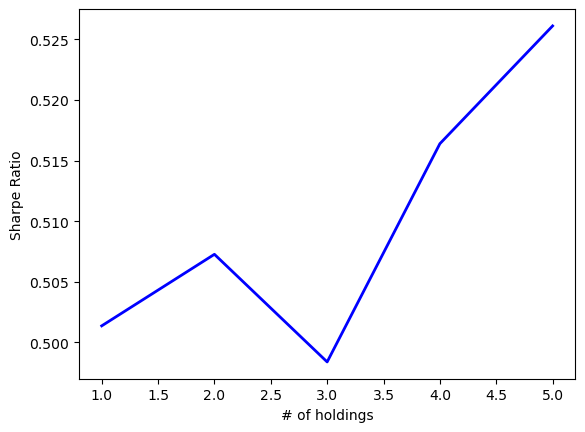

In [35]:
# Define parameters and initialize empty lists or arrays
holdings_loop = range(1, 6)
sharpRatio_holdings_loop = [0] * len(holdings_loop)

# Iterate over the investment horizons
for i, holdings in enumerate(holdings_loop):
    # Based on your MATLAB code, lookback period start is fixed at 9, lookback period end is fixed at 1
    _, xsReturns_mom_TC_lb, _, _ = pmpBacktestMomentum(returns_d, rf_d, numericDate_d, lookback_period_start, lookback_period_end, holding_period, tradingLag, startMonth, holdings, nShort, trx_cost)
    _, _, _, sharpRatio_mom, _, _, _, _, _, _, _ = summarizePerformance(xsReturns_mom_TC_lb, rf_d_monthly, returns_SPX_monthly, 12, startMonth, 'mom_inv_horizon')

    sharpRatio_holdings_loop[i] = sharpRatio_mom

# Plot the results
plt.figure()
plt.plot(holdings_loop, sharpRatio_holdings_loop, linewidth=myLineWidth, color=RobustnessCheckColor)
plt.xlabel("# of holdings")
plt.ylabel("Sharpe Ratio")
plt.savefig('Number Holdings_Check.jpg')
plt.show()

/var/folders/7m/vw_x51f92rbdyw9syfzqp4b80000gn/T/ipykernel_5322/3603478292.py:55: RuntimeWarning: divide by zero encountered in divide
  weights_short[month, :] /= total_short_weight
/var/folders/7m/vw_x51f92rbdyw9syfzqp4b80000gn/T/ipykernel_5322/3603478292.py:55: RuntimeWarning: invalid value encountered in divide
  weights_short[month, :] /= total_short_weight


Performance Statistics for mom_tx_costs
+----------------------+----------------+
|      Statistic       |     Value      |
+----------------------+----------------+
| ArithmAvgTotalReturn |  [9.78478786]  |
|  ArithmAvgXsReturn   |  [7.92700959]  |
|     StdXsReturns     | [15.90519145]  |
|   SharpeArithmetic   |  [0.49839133]  |
|   SharpeGeometric    |  [0.43833249]  |
|     MinXsReturn      | [-17.65697321] |
|     MaxXsReturn      | [13.92357367]  |
|     SkewXsReturn     | [-0.62847198]  |
|     KurtXsReturn     |  [1.50404537]  |
|   alphaArithmetic    | [1063.5586891] |
+----------------------+----------------+
Performance Statistics for mom_tx_costs
+----------------------+-----------------+
|      Statistic       |      Value      |
+----------------------+-----------------+
| ArithmAvgTotalReturn |   [9.52522812]  |
|  ArithmAvgXsReturn   |   [7.66744984]  |
|     StdXsReturns     |  [15.90857597]  |
|   SharpeArithmetic   |   [0.48196959]  |
|   SharpeGeometric    |   [0.4

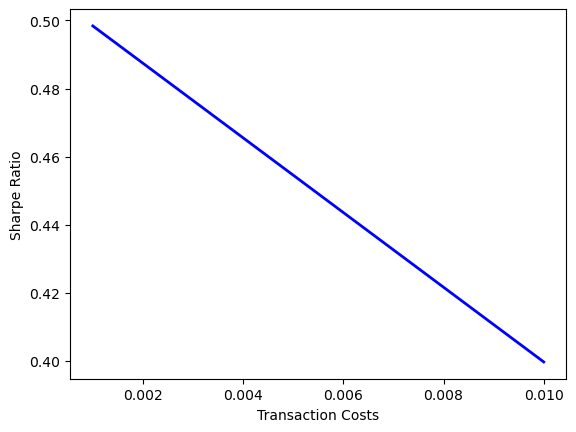

In [36]:
# Define parameters and initialize empty lists or arrays
tx_costs_loop = [0.001, 0.0025, 0.005, 0.01]
sharpRatio_tx_costs_loop = [0] * len(tx_costs_loop)

# Iterate over the transaction costs
for i, tx_cost in enumerate(tx_costs_loop):
    _, xsReturns_mom_TC_lb, _, _ = pmpBacktestMomentum(returns_d, rf_d, numericDate_d, lookback_period_start, lookback_period_end, holding_period, tradingLag, startMonth, nLong, nShort, tx_cost)
    _, _, _, sharpRatio_mom, _, _, _, _, _, _, _ = summarizePerformance(xsReturns_mom_TC_lb, rf_d_monthly, returns_SPX_monthly, 12, startMonth, 'mom_tx_costs')

    sharpRatio_tx_costs_loop[i] = sharpRatio_mom

# Plot the results
plt.figure()
plt.plot(tx_costs_loop, sharpRatio_tx_costs_loop, linewidth=myLineWidth, color=RobustnessCheckColor)
plt.xlabel("Transaction Costs")
plt.ylabel("Sharpe Ratio")
plt.savefig('TransactionCosts_Check.jpg')
plt.show()

In [37]:
# Robustness Checks (Holding period, lookback, tx costs, nHolding)
# How much is accounted for by just beeing in the right sectors (with hindsight)
# How heavily are the market weighted inexes concentrated
# PCA (Fabian)